# Projet de traitement de données massive

## Partie 1

### Collecte de données

#### Extract informations

Cloner le dataset depuis git


In [1]:
import git
# Check out via HTTPS
#git.Repo.clone_from('https://github.com/Lseig/Images_TDM.git', 'Images_git')


Extraction des informations des images


In [32]:
import PIL.Image
import os
import json
from sklearn.cluster import KMeans
import numpy
from colorthief import ColorThief
import time
import git
from IPython.display import display
from IPython.display import clear_output

from scipy.spatial import KDTree
from webcolors import hex_to_rgb
from webcolors import CSS3_HEX_TO_NAMES


class ImageAnalysis:
    def __init__(self, directory):
        self.extract_metadata(directory)

    def orientation(self, height, width):
        if height > width:
            return "Portrait"
        elif width > height:
            return "Paysage"
        else:
            return "Carre"
            
    def taille(self, height, width):
        if height*width >= (1200*900):
            return "Big"
        if height*width >= (500*500) and height*width < (1200*900):
            return "Medium"
        else:
            return "Small"

    def convert_rgb_to_names(self, rgb_tuple):
        # a dictionary of all the hex and their respective names in css3
        css3_db = CSS3_HEX_TO_NAMES
        names = []
        rgb_values = []
        for color_hex, color_name in css3_db.items():
            # Ajoute à la liste names les noms des couleurs
            names.append(color_name)
            rgb_values.append(hex_to_rgb(color_hex))

        kdt_db = KDTree(rgb_values)
        distance, index = kdt_db.query(rgb_tuple)
        return f'{names[index]}'

    def extract_metadata(self, directory_name):
        directory = os.fsencode(directory_name)
        dataDict = {}
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            img = PIL.Image.open(directory_name+"/"+filename)
            exif_data = img._getexif()
            color_thief = ColorThief(directory_name+"/"+filename)
            tabcolor = color_thief.get_palette(color_count=5)
            dataDict[filename] = {
                "Height": img.height,
                "Width": img.width,
                "Orientation": self.orientation(img.height, img.width),
                "Taille": self.taille(img.height, img.width),
                "Exif": str(exif_data),
                "Couleur dominante 1": (self.convert_rgb_to_names(tabcolor[0]), tabcolor[0]),
                "Couleur dominante 2": (self.convert_rgb_to_names(tabcolor[1]), tabcolor[1]),
                "Couleur dominante 3": (self.convert_rgb_to_names(tabcolor[2]), tabcolor[2]),
                "Couleur dominante 4": (self.convert_rgb_to_names(tabcolor[3]), tabcolor[3]),
                "Couleur dominante 5": (self.convert_rgb_to_names(tabcolor[4]), tabcolor[4])
            }

        with open('json_data.json', 'w') as outfile:
            json.dump(dataDict, outfile)


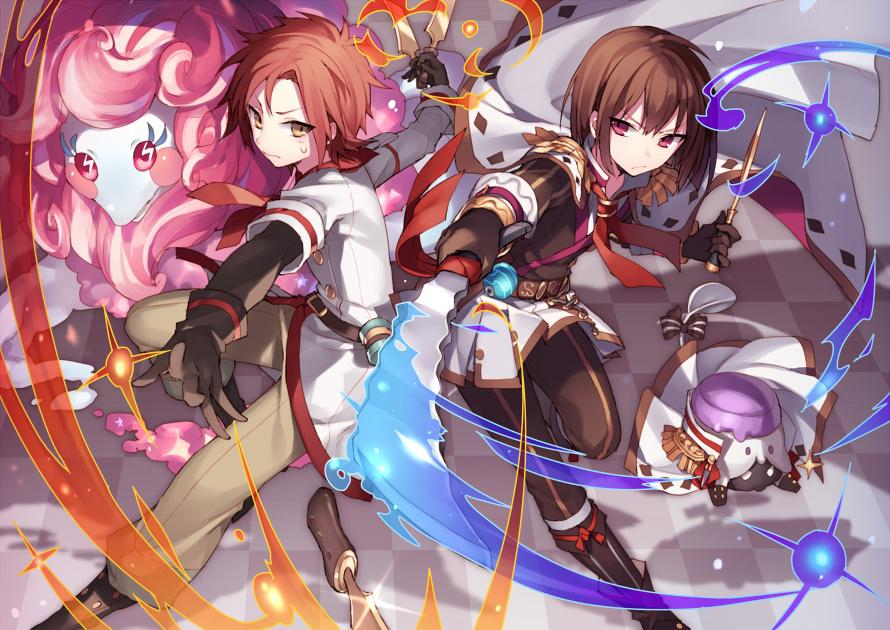

In [3]:
def generate_training_file():
    like_dict = {}
    dirName = "image_like"
    directory = os.fsencode(dirName)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        display(PIL.Image.open(dirName+"/"+filename))
        like = input("Entrer Y si vous aimez l'image" + filename +
                     " ou N si vous ne l'aimez pas ou U si vous n'avez pas d'avis")
        like_dict[filename] = {"like": like}
        clear_output(wait=True)

    with open('training_file.json', 'w') as outfile:
        json.dump(like_dict, outfile)


generate_training_file()


In [4]:
class LikeAnalysis:
    def __init__(self, training_file, image_folder):
        self.training_file = training_file
        imageAnalysis = ImageAnalysis(image_folder)
        self.like = []
        self.dislike = []
        self.aDict = {}
        self.image_folder = image_folder
        self.concatenateLikesAnalysis()
        

    def concatenateLikesAnalysis(self):
        '''
        Concatene le fichier d'entrainement de l'algorythme avec le fichier d'analyse des données des images afin de pouvoir
        etablir les gouts des utilisateurs
        '''
        
        analysis_file = open('json_data.json', 'r')
        self.aDict = json.load(analysis_file)
        analysis_file.close()

        training_fileA = open(self.training_file)
        likeDict = json.load(training_fileA)
        training_fileA.close()

        for x in self.aDict:
            for y in likeDict:
                if x == y:
                    if likeDict[y]["like"] == "y":
                        self.like.append(self.aDict[x])
                    elif likeDict[y]["like"] == "n":
                        self.dislike.append(self.aDict[x])
        

AnalysisResult = LikeAnalysis("training_file.json", "image_like")

In [78]:
class suggestionAlgorythm:

    def __init__(self, AnalysisResult):
        self.like = AnalysisResult.like
        self.dislike = AnalysisResult.dislike
        self.image_folder = AnalysisResult.image_folder
        self.aDict = AnalysisResult.aDict
        self.likeProfile = {}
        self.probaDict = {}
        self.calculateSizeLike()
        self.calculateOrientationLike()
        self.calculateColorLike()

    def calculateSizeLike(self):
        likeBig = 0
        likeSmall = 0
        likeMedium = 0

        for i in self.like:
            
            if i["Taille"] == "Big":
                likeBig += 2  
            elif i["Taille"] == "Medium":
                likeMedium += 2
            elif i["Taille"] == "Small":
                likeSmall +=2

        for j in self.dislike:
            
            if j["Taille"] == "Big":
                likeBig -= 1
            elif j["Taille"] == "Medium":
                likeMedium -= 1
            elif j["Taille"] == "Small":
                likeSmall -=1
                
        self.likeProfile["Big"]= (likeBig/(len(self.like)+len(self.dislike)))
        self.likeProfile["Medium"]=(likeMedium/(len(self.like)+len(self.dislike)))
        self.likeProfile["Small"]=(likeSmall/(len(self.like)+len(self.dislike)))
    
    def calculateOrientationLike(self):
        likePortrait = 0
        likeLandscape = 0
        likeCarre = 0

        for i in self.like:
            if i['Orientation'] == "Portrait":
                likePortrait +=2
            elif i['Orientation'] == "Paysage":
                likeLandscape += 2
            elif i["Orientation"] == "Carre":
                likeCarre +=2
        for j in self.dislike:
            if j['Orientation'] == "Portrait":
                likePortrait -=1
            elif j['Orientation'] == "Paysage":
                likeLandscape -= 1
            elif j["Orientation"] == "Carre":
                likeCarre -=1

        self.likeProfile["Portrait"] = (likePortrait/(len(self.like)+len(self.dislike)))
        self.likeProfile["Paysage"] = (likeLandscape/(len(self.like)+len(self.dislike)))
        self.likeProfile["Carre"] = (likeCarre/(len(self.like)+len(self.dislike)))

    def calculateColorLike(self):
        colorLikeDict = {}
        for key in CSS3_HEX_TO_NAMES.items():
            colorLikeDict[key[1]] = 0
        for i in self.like:
            colorLikeDict[i["Couleur dominante 1"][0]] += 3/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 2"][0]] += 2/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 3"][0]] += 1/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 4"][0]] += 0.5/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 5"][0]] += 0.25/(len(self.like)+len(self.dislike))
        for j in self.dislike:
            colorLikeDict[i["Couleur dominante 1"][0]] -= 3/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 2"][0]] -= 2/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 3"][0]] -= 1/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 4"][0]] -= 0.5/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 5"][0]] -= 0.25/(len(self.like)+len(self.dislike))
        self.likeProfile["Colors"] = colorLikeDict
        
    def calculateLikeProbability(self):
        for item in self.aDict.items():
            
            probaScore = self.likeProfile[item[1]["Taille"]]+self.likeProfile[item[1]["Orientation"]]+self.likeProfile['Colors'][item[1]["Couleur dominante 1"][0]]
            self.probaDict[item[0]] = probaScore
        

    def suggestImage(self, image_name):
        if self.probaDict[image_name] > 0.5:
            return True
        else:
            return False


t = suggestionAlgorythm(AnalysisResult)
t.calculateLikeProbability()
print(t.probaDict)
print(t.suggestImage('000007_jpg.rf.20db8b37a61ef9c1db6ea6d0053cddab.jpg'))


{'000009_jpg.rf.336766b7a7d26258652405ce89033003.jpg': 0.024999999999999967, '000007_jpg.rf.20db8b37a61ef9c1db6ea6d0053cddab.jpg': 0.7, '000003_jpg.rf.fffb8d15d61d1d6cc88bda7175d0b9a5.jpg': 0.024999999999999967, '000008_jpg.rf.530f5c98aaa1f6c8d628010a1b94c524.jpg': 0.30000000000000004, '000005_jpg.rf.ba68e5dd97a6b5672c196e8706759201.jpg': 0.6000000000000001, '000010_jpg.rf.04380f47736ca2bb8ba4bf5e82236346.jpg': 0.7, '000002_jpg.rf.d2f8fe262f2410c7a33fe6e4a1194ca8.jpg': 0.4, '000006_jpg.rf.a48206c1fdc49cd24fe2c6e31824d5ae.jpg': 0.7, '000001_jpg.rf.cc1d609d72e31acf4fecd768181f78ae.jpg': -0.7, '000011_jpg.rf.069eb69db5042daa2629d2cf03d313be.jpg': 0.6000000000000001}
True


In [ ]:
for key in CSS3_HEX_TO_NAMES.items():
    print( key[1])